# Plot Seasonal Variation in Precipitation and Temperature
## 1. Import required Python libraries

In [1]:
import netCDF4 as nc
import xarray as xr
import numpy as np
import scipy
import scipy.stats as stats
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import LC_Grid_Labels as lc
import cartopy
import cartopy.crs as crs
from cartopy.feature import NaturalEarthFeature
import wrf
from wrf import (to_np, getvar, smooth2d, get_cartopy, cartopy_xlim,
                 cartopy_ylim, latlon_coords)
import IPython

### 1. a. Print session and library version numbers  

In [2]:
# Print IPython Session Info
print(IPython.sys_info())

# Print versions of libraries used in this notebook for traceability
print("\nPackage version numbers:\n")
print("xarray version: " + xr.__version__)
print("numpy version: " + np.__version__)
print("scipy version: " + scipy.__version__)
print("matplotlib version: " + matplotlib.__version__)
print("cartopy: " + cartopy.__version__)
print("wrf-python version: " + wrf.__version__+"\n")

{'commit_hash': '8c47bbcb3',
 'commit_source': 'installation',
 'default_encoding': 'UTF-8',
 'ipython_path': '/Users/lejoflores/miniconda3/lib/python3.7/site-packages/IPython',
 'ipython_version': '7.5.0',
 'os_name': 'posix',
 'platform': 'Darwin-18.6.0-x86_64-i386-64bit',
 'sys_executable': '/Users/lejoflores/miniconda3/bin/python',
 'sys_platform': 'darwin',
 'sys_version': '3.7.3 (default, Mar 27 2019, 16:54:48) \n'
                '[Clang 4.0.1 (tags/RELEASE_401/final)]'}

Package version numbers:

xarray version: 0.12.1
numpy version: 1.16.3
scipy version: 1.2.1
matplotlib version: 3.0.3
cartopy: 0.17.0
wrf-python version: 1.3.2



## 2. Read in the data using ```xarray```

In [3]:
wrf_dir = '/Users/lejoflores/data/WRF-NARR-1km-Daily/'

ds_wrf = xr.open_mfdataset(wrf_dir+'WRF-NARR*.nc')

## 2. a. Create a month of the water year array to use as a grouping variable

In [4]:
WY1 = (ds_wrf['XTIME.year'].where(ds_wrf['XTIME.month'] >= 10).values + 1)
WY2 = (ds_wrf['XTIME.year'].where(ds_wrf['XTIME.month'] < 10).values)
WY = np.nansum(np.column_stack((WY1,WY2)),axis=1)

WY_MO = ds_wrf['XTIME.month'].values - 9
WY_MO[WY_MO<=0] += 12

## 2. b. Add the month of water year array to the dataset

In [5]:
ds_wrf.coords['WY'] = xr.DataArray(WY.astype(int),dims='XTIME')
ds_wrf.coords['WY_MO'] = xr.DataArray(WY_MO.astype(int),dims='XTIME')
ds_wrf

<xarray.Dataset>
Dimensions:  (XTIME: 10958, south_north: 327, west_east: 348)
Coordinates:
  * XTIME    (XTIME) datetime64[ns] 1987-10-01 1987-10-02 ... 2017-09-30
    WY       (XTIME) int64 1988 1988 1988 1988 1988 ... 2017 2017 2017 2017 2017
    WY_MO    (XTIME) int64 1 1 1 1 1 1 1 1 1 1 ... 12 12 12 12 12 12 12 12 12 12
Dimensions without coordinates: south_north, west_east
Data variables:
    DPRCP    (XTIME, south_north, west_east) float32 dask.array<shape=(10958, 327, 348), chunksize=(366, 327, 348)>
    TMEAN    (XTIME, south_north, west_east) float32 dask.array<shape=(10958, 327, 348), chunksize=(366, 327, 348)>
    Q2       (XTIME, south_north, west_east) float32 dask.array<shape=(10958, 327, 348), chunksize=(366, 327, 348)>
    SWDOWN   (XTIME, south_north, west_east) float32 dask.array<shape=(10958, 327, 348), chunksize=(366, 327, 348)>
    SWNORM   (XTIME, south_north, west_east) float32 dask.array<shape=(10958, 327, 348), chunksize=(366, 327, 348)>
    TMIN     (XTIME, s

# 3. Compute monthly statistics 

In [6]:
ds_mon = xr.Dataset()

ds_mon['MPRCP'] = ds_wrf['DPRCP'].resample(XTIME='1MS').sum(dim='XTIME')
ds_mon['TMAX'] = ds_wrf['TMAX'].resample(XTIME='1MS').mean(dim='XTIME')
ds_mon['TMIN'] = ds_wrf['TMIN'].resample(XTIME='1MS').mean(dim='XTIME')
ds_mon.coords['WY_MO'] = xr.DataArray(ds_wrf['WY_MO'].resample(XTIME='1MS').first(),dims='XTIME')

ds_mon = ds_mon.groupby('WY_MO').mean(dim='XTIME')
ds_mon

<xarray.Dataset>
Dimensions:  (WY_MO: 12, south_north: 327, west_east: 348)
Coordinates:
  * WY_MO    (WY_MO) int64 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: south_north, west_east
Data variables:
    MPRCP    (WY_MO, south_north, west_east) float32 dask.array<shape=(12, 327, 348), chunksize=(1, 327, 348)>
    TMAX     (WY_MO, south_north, west_east) float32 dask.array<shape=(12, 327, 348), chunksize=(1, 327, 348)>
    TMIN     (WY_MO, south_north, west_east) float32 dask.array<shape=(12, 327, 348), chunksize=(1, 327, 348)>

# 4. Plot monthly averages

In [7]:
ds_wrfgeo = xr.open_dataset(wrf_dir+'wrf_geoinfo.nc')
nc_wrfgeo = nc.Dataset(wrf_dir+'wrf_geoinfo.nc')
cart_proj = get_cartopy(wrfin=nc_wrfgeo)

lats, lons = latlon_coords(ds_wrfgeo)

lat = lats[0]
lon = lons[0]

states = NaturalEarthFeature(category='cultural', scale='10m',facecolor='none',name='admin_1_states_provinces_shp')
rivers = NaturalEarthFeature(category='physical',scale='10m',facecolor='none',name='rivers_lake_centerlines')

plt.rcParams.update({'font.size': 8, 'font.family':'sans-serif'})

xticks = [-118,-117,-116,-115,-114,-113]
yticks = [42,43,44,45,46]

fig_ids = ['(a) OCT','(b) NOV','(c) DEC',
           '(d) JAN','(e) FEB','(f) MAR',
           '(g) APR','(h) MAY','(i) JUN',
           '(j) JUL','(k) AUG','(l) SEP']

figsize_in = (8.5,11.25)
figres_dpi = 300
figext = '.tif'

contour_levels = 10

PrcpCycle_fname = 'fig/3_PrcpSeasonalCycle'+figext
TminCycle_fname = 'fig/4_TminSeasonalCycle'+figext
TmaxCycle_fname = 'fig/5_TmaxSeasonalCycle'+figext

### 4. a.  Plot precipitation seasonal cycle

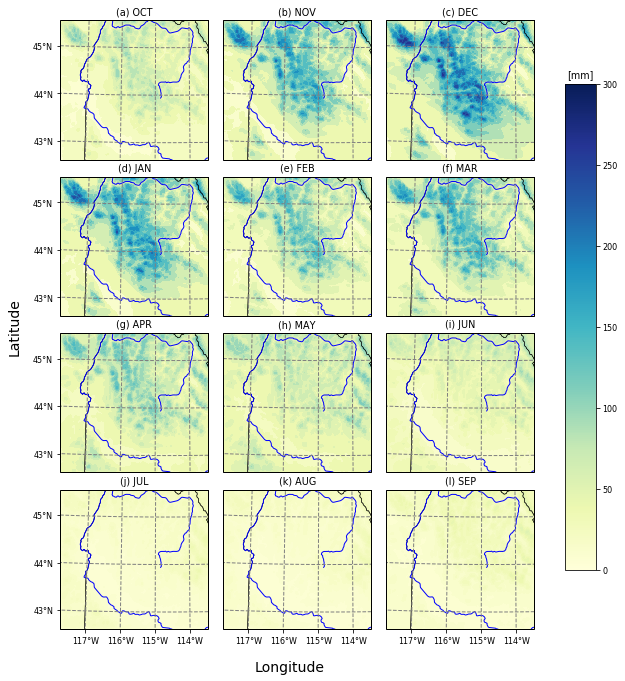

In [8]:
prcp_vmin = 0.0
prcp_vmax = 300.0

fig, axes = plt.subplots(ncols=3, nrows=4, figsize=figsize_in, subplot_kw = {'projection': cart_proj})
fig.subplots_adjust(wspace = .1, hspace = .1)

Month = 0
for ax in axes.flat:
    im = ax.contourf(to_np(lon),to_np(lat),to_np(ds_mon.MPRCP[Month]),contour_levels,transform=crs.PlateCarree(),cmap='YlGnBu',
               vmin=prcp_vmin, vmax=prcp_vmax)
    ax.add_feature(states, linewidth=0.5, edgecolor='black')
    ax.add_feature(rivers, linewidth=1.0, edgecolor='b')
    fig.canvas.draw()
    ax.gridlines(xlocs=xticks, ylocs=yticks, color='gray', linestyle='--', linewidth=1)
    ax.set_title(fig_ids[Month])
    
    if(ax.rowNum==3):
        ax.xaxis.set_major_formatter(lc.LONGITUDE_FORMATTER) 
        lc.lambert_xticks(ax, xticks)
    
    if(ax.colNum==0):
        ax.yaxis.set_major_formatter(lc.LATITUDE_FORMATTER)
        lc.lambert_yticks(ax, yticks)

    Month += 1

cbar_ax = fig.add_axes([0.95, 0.2, 0.05, 0.6])

m = plt.cm.ScalarMappable(cmap=cm.YlGnBu)
m.set_array(to_np(ds_mon.MPRCP[0]))
m.set_clim(prcp_vmin, prcp_vmax)

clb = fig.colorbar(m,cax = cbar_ax)
clb.ax.set_title('[mm]')

fig.text(0.5, 0.08, 'Longitude', ha='center', va='center', fontsize=14)
fig.text(0.05, 0.5, 'Latitude', ha='center', va='center', rotation='vertical', fontsize=14)

plt.savefig(PrcpCycle_fname, dpi=figres_dpi, facecolor='w', edgecolor='w', orientation='landscape', bbox_inches='tight')
plt.show()

### 4. b. Plot minimum daily temperature seasonal cycle

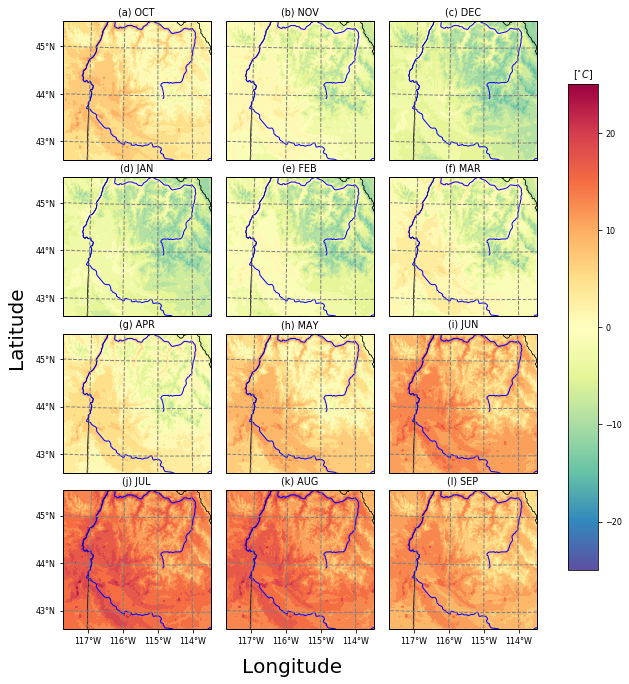

In [9]:
tmin_vmin = -25.0
tmin_vmax = 25.0

fig, axes = plt.subplots(ncols=3, nrows=4, figsize=figsize_in, subplot_kw = {'projection': cart_proj})
fig.subplots_adjust(wspace = .1, hspace = .1)

Month = 0
for ax in axes.flat:
    im = ax.contourf(to_np(lon),to_np(lat),to_np(ds_mon.TMIN[Month] - 273.15),contour_levels,transform=crs.PlateCarree(),
                     cmap='Spectral_r', vmin=tmin_vmin, vmax=tmin_vmax)
    ax.add_feature(states, linewidth=0.5, edgecolor='black')
    ax.add_feature(rivers, linewidth=1.0, edgecolor='b')
    fig.canvas.draw()
    ax.gridlines(xlocs=xticks, ylocs=yticks, color='gray', linestyle='--', linewidth=1)
    ax.set_title(fig_ids[Month])
    
    if(ax.rowNum==3):
        ax.xaxis.set_major_formatter(lc.LONGITUDE_FORMATTER) 
        lc.lambert_xticks(ax, xticks)
    
    if(ax.colNum==0):
        ax.yaxis.set_major_formatter(lc.LATITUDE_FORMATTER)
        lc.lambert_yticks(ax, yticks)

    Month += 1

cbar_ax = fig.add_axes([0.95, 0.2, 0.05, 0.6])

m = plt.cm.ScalarMappable(cmap=cm.Spectral_r)
m.set_array(to_np(ds_mon.TMIN[0]))
m.set_clim(tmin_vmin, tmin_vmax)

clb = fig.colorbar(m,cax = cbar_ax)
clb.ax.set_title('[${}^{\circ}C$]')

fig.text(0.5, 0.08, 'Longitude', ha='center', va='center', fontsize=20)
fig.text(0.05, 0.5, 'Latitude', ha='center', va='center', rotation='vertical', fontsize=20)

plt.savefig(TminCycle_fname, dpi=figres_dpi, facecolor='w', edgecolor='w', orientation='landscape', bbox_inches='tight')
plt.show()

### 4. c. Plot daily maximum temperature seasonal cycle

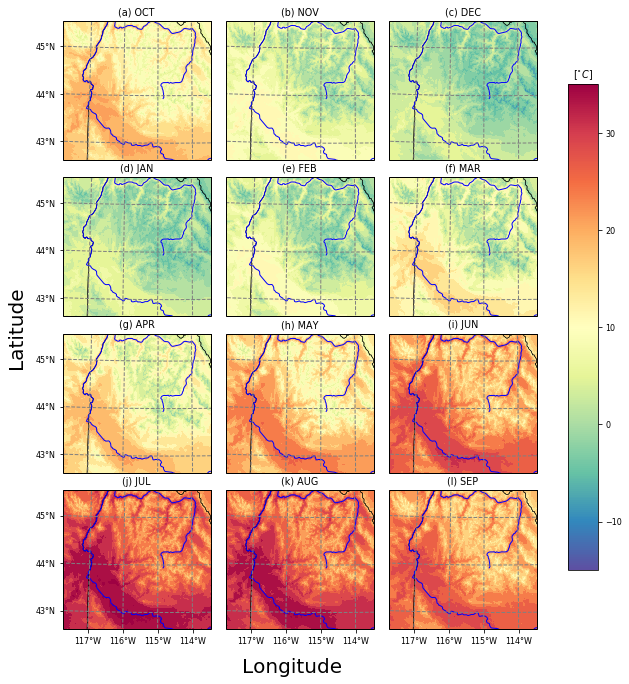

In [10]:
tmax_vmin = -15.0
tmax_vmax = 35.0

fig, axes = plt.subplots(ncols=3, nrows=4, figsize=figsize_in, subplot_kw = {'projection': cart_proj})
fig.subplots_adjust(wspace = .1, hspace = .1)

Month = 0
for ax in axes.flat:
    im = ax.contourf(to_np(lon),to_np(lat),to_np(ds_mon.TMAX[Month] - 273.15),contour_levels,transform=crs.PlateCarree(),
                     cmap='Spectral_r', vmin=tmax_vmin, vmax=tmax_vmax)
    ax.add_feature(states, linewidth=0.5, edgecolor='black')
    ax.add_feature(rivers, linewidth=1.0, edgecolor='b')
    fig.canvas.draw()
    ax.gridlines(xlocs=xticks, ylocs=yticks, color='gray', linestyle='--', linewidth=1)
    ax.set_title(fig_ids[Month])
    
    if(ax.rowNum==3):
        ax.xaxis.set_major_formatter(lc.LONGITUDE_FORMATTER) 
        lc.lambert_xticks(ax, xticks)
    
    if(ax.colNum==0):
        ax.yaxis.set_major_formatter(lc.LATITUDE_FORMATTER)
        lc.lambert_yticks(ax, yticks)

    Month += 1

cbar_ax = fig.add_axes([0.95, 0.2, 0.05, 0.6])

m = plt.cm.ScalarMappable(cmap=cm.Spectral_r)
m.set_array(to_np(ds_mon.TMAX[0]))
m.set_clim(tmax_vmin, tmax_vmax)

clb = fig.colorbar(m,cax = cbar_ax)
clb.ax.set_title('[${}^{\circ}C$]')

fig.text(0.5, 0.08, 'Longitude', ha='center', va='center', fontsize=20)
fig.text(0.05, 0.5, 'Latitude', ha='center', va='center', rotation='vertical', fontsize=20)

plt.savefig(TmaxCycle_fname, dpi=figres_dpi, facecolor='w', edgecolor='w', orientation='landscape', bbox_inches='tight')
plt.show()


### 4. d. Plot seasonal cycle of spatial average precipitation

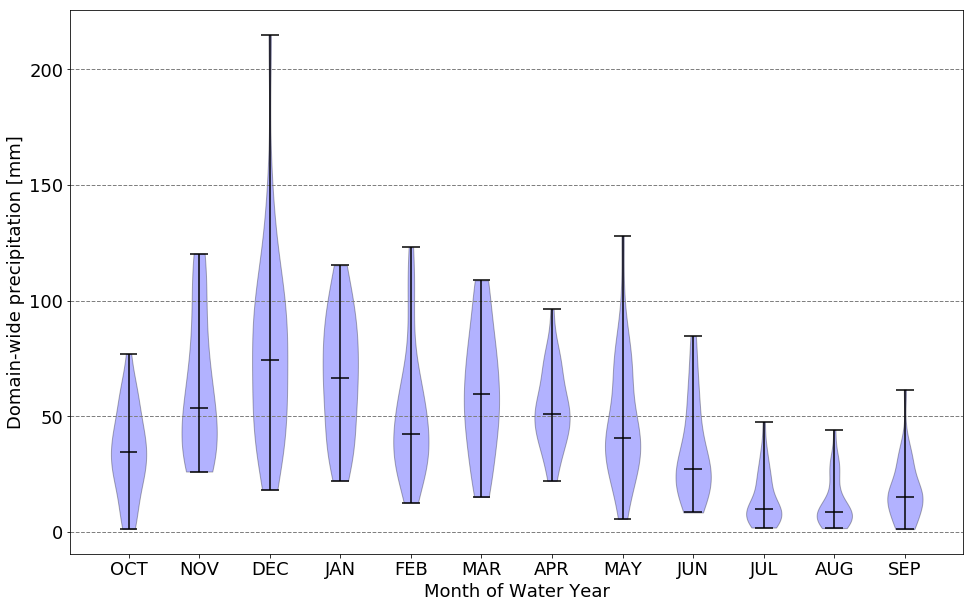

In [11]:
plt.rcParams.update({'font.size': 18, 'font.family':'sans-serif'})

prcp_spatialavg = ds_wrf['DPRCP'].mean(dim=('south_north','west_east')).resample(XTIME='1MS').sum().values
prcp_spatialavg = prcp_spatialavg.reshape(30,12)

fig,ax = plt.subplots(figsize=(16,10))

violin_parts = ax.violinplot(prcp_spatialavg,showmeans=False,showmedians=True,showextrema=True)

for pc in violin_parts['bodies']:
    pc.set_facecolor('b')
    pc.set_edgecolor('k')
    pc.set_alpha(0.3)

violin_parts['cmaxes'].set_edgecolor('k')
violin_parts['cmins'].set_edgecolor('k')
violin_parts['cbars'].set_edgecolor('k')
violin_parts['cmedians'].set_edgecolor('k')
  
ax.set_xticks(np.arange(12)+1)
ax.set_xticklabels(['OCT','NOV','DEC','JAN','FEB','MAR','APR','MAY','JUN','JUL','AUG','SEP'])
ax.set_xlabel('Month of Water Year')
ax.set_ylabel('Domain-wide precipitation [mm]')
ax.yaxis.grid(which="major", color='gray', linestyle='--', linewidth=1)

plt.savefig('fig/6_PrcpAreaAvgCycle.tif', dpi=300, facecolor='w', edgecolor='w', orientation='landscape', bbox_inches='tight')

plt.show()

### 4. e. Plot seasonal cycle of air temperature

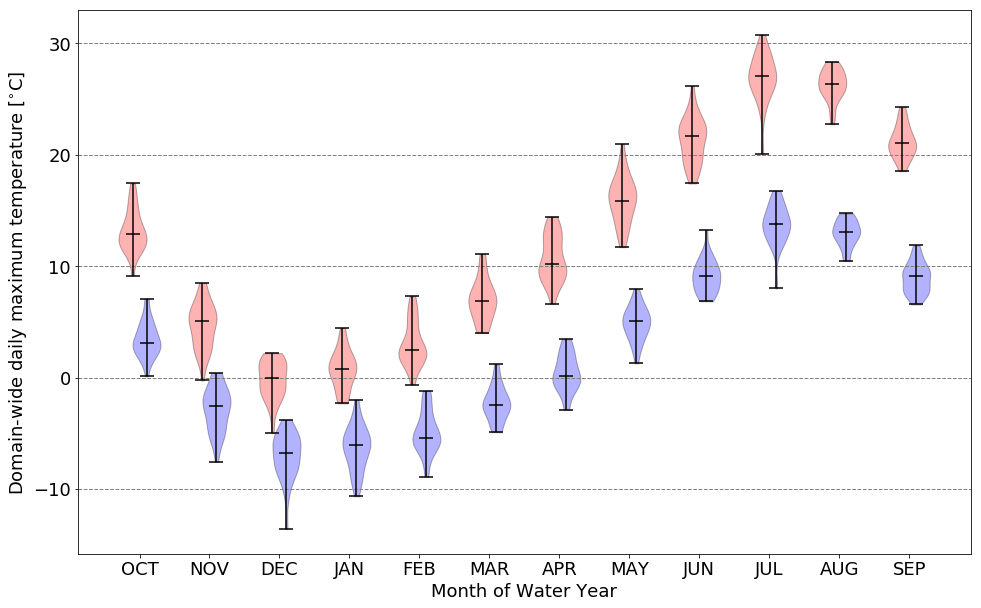

In [12]:
plt.rcParams.update({'font.size': 18, 'font.family':'sans-serif'})

tmax_spatialavg = ds_wrf['TMAX'].mean(dim=('south_north','west_east')).resample(XTIME='1MS').mean().values
tmax_spatialavg = tmax_spatialavg.reshape(30,12)

tmin_spatialavg = ds_wrf['TMIN'].mean(dim=('south_north','west_east')).resample(XTIME='1MS').mean().values
tmin_spatialavg = tmin_spatialavg.reshape(30,12)

t_stack_spatialavg = np.dstack((tmax_spatialavg,tmin_spatialavg)).reshape(tmin_spatialavg.shape[0],-1) - 273.15

pos1 = np.linspace(0.9,11.9,12)
pos2 = np.linspace(1.1,12.1,12)

pos = np.dstack((pos1,pos2)).reshape(2*pos1.size)

fig,ax = plt.subplots(figsize=(16,10))

violin_parts = ax.violinplot(t_stack_spatialavg,pos,widths=0.4,showmeans=False,showmedians=True,showextrema=True)

count = 1
for pc in violin_parts['bodies']:
    if(count % 2 == 0):
        pc.set_facecolor('b')
    else:
        pc.set_facecolor('r')
    pc.set_edgecolor('k')
    pc.set_alpha(0.3)
    count += 1

violin_parts['cmaxes'].set_edgecolor('k')
violin_parts['cmins'].set_edgecolor('k')
violin_parts['cbars'].set_edgecolor('k')
violin_parts['cmedians'].set_edgecolor('k')
  
ax.set_xticks(np.arange(12)+1)
ax.set_xticklabels(['OCT','NOV','DEC','JAN','FEB','MAR','APR','MAY','JUN','JUL','AUG','SEP'])
ax.set_xlabel('Month of Water Year')
ax.set_ylabel('Domain-wide daily maximum temperature [${}^{\circ}$C]')
ax.yaxis.grid(which="major", color='gray', linestyle='--', linewidth=1)

plt.savefig('fig/7_TempAreaAvgCycle.tif', dpi=300, facecolor='w', edgecolor='w', orientation='landscape', bbox_inches='tight')

plt.show()